# Modeling

In this notebook we will make use of the features we engineered in the last section to build a more robust model that we can use for predicting ETA. 

First we will prepare our data for modeling and then we will train three different models and evaluate their predictions using the scoring function we created.

We will train the models on all the dataset and also on data for specific routes, with one or more instances of trips in each route (depending on the data that is available).

In [30]:
import sklearn
import pandas as pd

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

import time
import tools

from sklearn.utils import shuffle
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression


Let's load the feature engineered data we saved in the last notebook.

In [31]:
df_trips_stops = pd.read_csv('data/3_modeling/enhanced_data.csv')

In [32]:
df_trips_stops = shuffle(df_trips_stops)
df_trips_stops.shape

(589448, 13)

Looks good!

In [33]:
df_trips_stops.head()

,index,rt_trip_id,rt_stop_id,stop_offset,departure,lat,lng,distance_prev,departure_date,dist_to_start,time_sec_prev,arrival_ax_date,speed_mps_prev
68007,147224,203579963,54132,34,1568630457,45.640849,-73.495174,181.0,2019-09-16 10:40:57,4.154322e+15,28.0,2019-09-16 10:39:27,6.464286
69193,148410,203579975,53659,63,1568685300,45.651973,-73.489247,441.0,2019-09-17 01:55:00,9.506173e+23,60.0,2019-09-17 01:53:30,7.350000
544946,298576,205384651,56348,2,1568655983,45.466102,-73.668374,224.0,2019-09-16 17:46:23,2.190000e+02,42.0,2019-09-16 17:44:53,5.333333
157482,173549,203894642,51950,30,1568631828,45.491562,-73.587759,223.0,2019-09-16 11:03:48,7.125913e+13,48.0,2019-09-16 11:02:18,4.645833
465099,429712,204905772,50192,7,1568655674,45.524675,-73.708448,166.0,2019-09-16 17:41:14,4.216000e+04,30.0,2019-09-16 17:39:44,5.533333


***df_trips_stops*** represents all the data across all route. We'll use it for modeling bellow.

In [34]:
df_grouped_by_trip = df_trips_stops.groupby('rt_trip_id')

In [35]:
sample_route_id = 201874899
df_per_trip = df_grouped_by_trip.get_group(sample_route_id) 
df_per_trip.head()

,index,rt_trip_id,rt_stop_id,stop_offset,departure,lat,lng,distance_prev,departure_date,dist_to_start,time_sec_prev,arrival_ax_date,speed_mps_prev
128,37690,201874899,51611,57,1568619140,45.446874,-73.602166,253.0,2019-09-16 07:32:20,2.498104e+21,35.0,2019-09-16 07:30:50,7.228571
144,37706,201874899,56885,74,1568619952,45.438205,-73.623777,203.0,2019-09-16 07:45:52,1.216788e+28,21.0,2019-09-16 07:44:22,9.666667
143,37705,201874899,56899,73,1568619931,45.439662,-73.622194,125.0,2019-09-16 07:45:31,4.647717e+27,17.0,2019-09-16 07:44:01,7.352941
119,37681,201874899,51961,48,1568618700,45.457315,-73.587930,231.0,2019-09-16 07:25:00,4.323475e+17,34.0,2019-09-16 07:23:30,6.794118
121,37683,201874899,51836,50,1568618775,45.457172,-73.592732,183.0,2019-09-16 07:26:15,2.963354e+18,36.0,2019-09-16 07:24:45,5.083333


df_per_trip is the data that corresponds to route 201874899. We'll use it for modeling beloow

## Preparing data for modeling

Let's define the methods that will allow us to process our data so it can be put into our models. We will split the data by trip_id and take only data for one trip to train our models first, then we will train over all the dataset. We will then compare the results making use of the scoring function we came up with in the last section.

In [36]:
def numerize_date_feature(train):
    train_num_dates = pd.to_datetime(pd.to_datetime(train.values, format='%Y-%m-%d', errors='coerce')).astype(np.int64)
    return train_num_dates

def normalize_numerical_feature(feature):
    return feature.values/max(feature.values)

In [37]:
def prepare_data_for_modeling(dataframe):
    distance_prev = normalize_numerical_feature(dataframe['distance_prev'])
    speed_prev  = normalize_numerical_feature(dataframe['speed_mps_prev'])
    time_prev  = normalize_numerical_feature(dataframe['time_sec_prev'])
    lat  = normalize_numerical_feature(dataframe['lat'])
    lng = normalize_numerical_feature(dataframe['lng'])
    test_lng = normalize_numerical_feature(dataframe['lng'])
    
    departure = numerize_date_feature(dataframe['departure_date'])
    
    return list(zip(distance_prev, 
                   time_prev,
                   speed_prev,
                   departure,
                   lat, 
                   lng))

In [38]:
def split_data(data, training_percentage):
    df_trips_stops_train = data[:int(len(data)*training_percentage)]
    df_trips_stops_test = data[len(df_trips_stops_train):]

    assert len(data) == len(df_trips_stops_train)+len(df_trips_stops_test)
    
    return df_trips_stops_train, df_trips_stops_test
    

In [39]:
def prepare_X_data(data, training_percentage):

    df_trips_stops_train, df_trips_stops_test = split_data(data, training_percentage)
    
    return prepare_data_for_modeling(df_trips_stops_train), prepare_data_for_modeling(df_trips_stops_test)

def prepare_y_data(data, training_percentage):
    df_trips_stops_train, df_trips_stops_test = split_data(data, training_percentage)
   
    train_etas = numerize_date_feature(df_trips_stops_train['arrival_ax_date'])
    test_etas = numerize_date_feature(df_trips_stops_test['arrival_ax_date'])
    
    return train_etas, test_etas

The previous functions will be reused to prepare the data in both cases we will explore below.

### Modeling

We will train a gradient boosting regressor, random forest regressor and a traditional linear regression on our data. Bellow we define a list with the initialized models passing the 'out of the box' parameters. This should be good enough to start.

In [40]:
model_keys = ['gb_eta', 'rf_eta', 'lr_eta']
model_list = [GradientBoostingRegressor(random_state=1, n_estimators=10),
              RandomForestRegressor(random_state=1, n_estimators=10),
              LinearRegression()]

In [41]:
def train_predict(model_list, data):
    all_model_predictions = []
    X_train, X_test = prepare_X_data(data, 0.8)
    train_etas, test_etas = prepare_y_data(data, 0.8)
    for model in model_list:
        model.fit(X_train, train_etas)
        preds = model.predict(X_test)
        preds_as_dates = pd.to_datetime(preds)
        
        all_model_predictions.append((preds, preds_as_dates))
    return all_model_predictions
        

In [42]:
def predict_eta(model_list, data):
    predictions_per_trip = train_predict(model_list, data)
    df_trips_stops_train, df_trips_stops_test = split_data(data, 0.8)
    print(df_trips_stops_test.shape)

    gp_predicted_dates = predictions_per_trip[0][1]
    print(len(gp_predicted_dates))
    rf_predicted_dates = predictions_per_trip[1][1]
    lr_predicted_dates = predictions_per_trip[2][1]

    df_trips_stops_test.insert(len(df_trips_stops_test.columns), "gb_eta", gp_predicted_dates, True)
    df_trips_stops_test.insert(len(df_trips_stops_test.columns), "rf_eta", rf_predicted_dates, True)
    df_trips_stops_test.insert(len(df_trips_stops_test.columns), "lr_eta", lr_predicted_dates, True)
    
    return df_trips_stops_test

### Predict eta for each route

Let's train the models! Here we will train our three models for one specific trip (df_per_trip).

In [51]:
df_eta_per_trip = predict_eta(model_list, df_per_trip)
df_eta_per_trip.head()

(17, 13)
17


,index,rt_trip_id,rt_stop_id,stop_offset,departure,lat,lng,distance_prev,departure_date,dist_to_start,time_sec_prev,arrival_ax_date,speed_mps_prev,gb_eta,rf_eta,lr_eta
161,37723,201874899,56814,103,1568620920,45.417044,-73.639470,271.0,2019-09-16 08:02:00,1.551653e+35,32.0,2019-09-16 08:00:30,8.468750,2019-09-16 07:47:57.185905152,2019-09-16 07:58:39.533333504,2019-09-16 08:00:30.000000512
84,37646,201874899,53031,3,1568616480,45.518928,-73.552353,1714.0,2019-09-16 06:48:00,5.910000e+02,336.0,2019-09-16 06:46:30,5.101190,2019-09-16 07:01:35.158099200,2019-09-16 06:46:32.766666752,2019-09-16 06:46:30.000000512
158,37720,201874899,57099,100,1568620844,45.416324,-73.632239,348.0,2019-09-16 08:00:44,8.647068e+33,49.0,2019-09-16 07:59:14,7.102041,2019-09-16 07:47:57.185905152,2019-09-16 07:57:58.433333760,2019-09-16 07:59:14.000000512
91,37653,201874899,52783,10,1568616772,45.508667,-73.561939,282.0,2019-09-16 06:52:52,8.560910e+05,52.0,2019-09-16 06:51:22,5.423077,2019-09-16 07:02:55.245979904,2019-09-16 06:50:08.050000128,2019-09-16 06:51:22.000000512
115,37677,201874899,56531,44,1568618558,45.454680,-73.580780,233.0,2019-09-16 07:22:38,9.203050e+15,38.0,2019-09-16 07:21:08,6.131579,2019-09-16 07:22:26.732291072,2019-09-16 07:20:32.100000000,2019-09-16 07:21:08.000000512


Let's plot our predictions

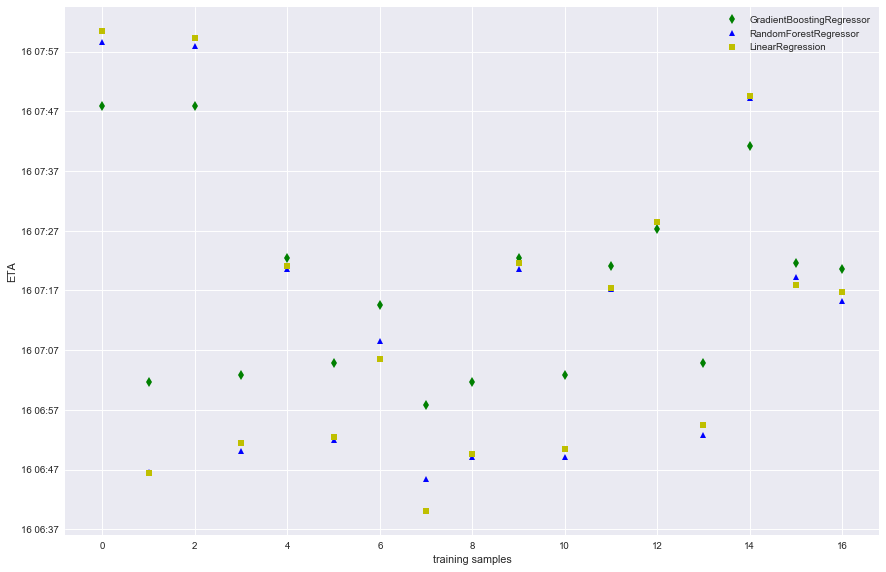

In [52]:
plt.figure()
plt.figure(figsize=(15, 10), dpi=70)
plt.plot(df_eta_per_trip['gb_eta'].values, 'gd', label='GradientBoostingRegressor')
plt.plot(df_eta_per_trip['rf_eta'].values, 'b^', label='RandomForestRegressor')
plt.plot(df_eta_per_trip['lr_eta'].values, 'ys', label='LinearRegression')
plt.ylabel('ETA')
plt.xlabel('training samples')
plt.legend(loc="best")
plt.show()

#### Score 

Let's make use of the scoring function that we created in the other notebook to evaluate how good our predictions are 

In [53]:
def test_predictions(data):
    for key in model_keys :
        print('Score: ' + key + ': ' + str(tools.score_eta_predictions(data,key, 'arrival_ax_date', 10)[0]))
        print('\n')

In [54]:
test_predictions(df_eta_per_trip)

Score: gb_eta: 0.033950617284


Score: rf_eta: 0.583333333333


Score: lr_eta: 0.944444444444




We have some scores. According to the scoring function we defined the random forest regressor does the best job at predicting the etas.

### Predict eta using all the dataset

Here we will put all the data we have into our models.

In [22]:
df_eta_all = predict_eta(model_list, df_trips_stops)
df_eta_all.head()

(117890, 13)
117890


,index,rt_trip_id,rt_stop_id,stop_offset,departure,lat,lng,distance_prev,departure_date,dist_to_start,time_sec_prev,arrival_ax_date,speed_mps_prev,gb_eta,rf_eta,lr_eta
269921,399834,204030915,56861,32,1568656560,45.421882,-73.629622,344.0,2019-09-16 17:56:00,9.490605e+14,60.0,2019-09-16 17:54:30,5.733333,2019-09-16 17:54:10.356980480,2019-09-16 17:51:30.340132096,2019-09-16 17:54:30.000013056
440343,125559,204904999,51239,26,1568632260,45.542895,-73.617832,264.0,2019-09-16 11:11:00,3.519665e+12,60.0,2019-09-16 11:09:30,4.400000,2019-09-16 13:30:19.140464896,2019-09-16 11:08:22.584050944,2019-09-16 11:09:30.000013056
555157,266096,205385173,55621,31,1568657443,45.489376,-73.685056,688.0,2019-09-16 18:10:43,4.319614e+14,63.0,2019-09-16 18:09:13,10.920635,2019-09-16 18:04:41.677811712,2019-09-16 18:08:13.249797632,2019-09-16 18:09:13.000013056
96477,250523,203581293,51421,5,1568633276,45.632908,-73.607148,178.0,2019-09-16 11:27:56,3.195000e+03,30.0,2019-09-16 11:26:26,5.933333,2019-09-16 13:30:19.140464896,2019-09-16 11:26:51.091195136,2019-09-16 11:26:26.000013056
545808,248297,205384681,56408,11,1568668597,45.476705,-73.651772,137.0,2019-09-16 21:16:37,1.443060e+06,37.0,2019-09-16 21:15:07,3.702703,2019-09-16 19:52:26.608231936,2019-09-16 21:13:49.632574976,2019-09-16 21:15:07.000013056


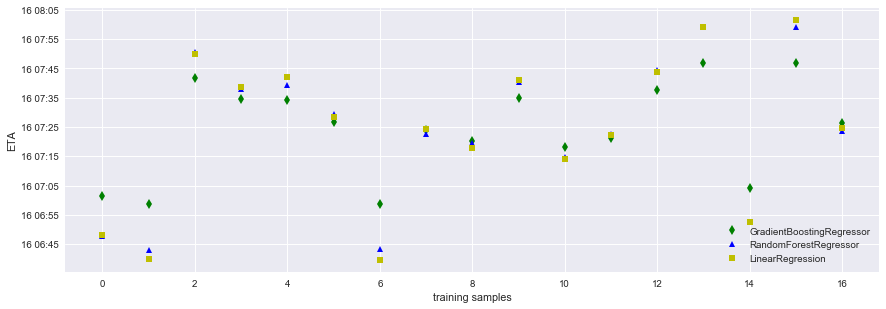

In [23]:
plt.figure()
plt.figure(figsize=(15, 5), dpi=70)
plt.plot(df_eta_per_trip['gb_eta'].values, 'gd', label='GradientBoostingRegressor')
plt.plot(df_eta_per_trip['rf_eta'].values, 'b^', label='RandomForestRegressor')
plt.plot(df_eta_per_trip['lr_eta'].values, 'ys', label='LinearRegression')
plt.ylabel('ETA')
plt.xlabel('training samples')
plt.legend(loc="best")
plt.show()

In [24]:
test_predictions(df_eta_all)

Score: gb_eta: 0.0116768576785


Score: rf_eta: 0.447140844926


Score: lr_eta: 0.999991517588




According to our scoring function the random forest regressor does the best job. The linear regression seems to be overfitting also in this case.

In [25]:
df_eta_all.to_csv ('data/4_results/df_eta_all_results.csv', index = None, header=True)
df_eta_per_trip.to_csv ('data/4_results/df_eta_trip_results.csv', index = None, header=True)

## Conclusion

We have arrived to train several models of different complexities. All of them with the assumption that we could trust the data provided to us as 'departure_date' since we've used it to approximate bus arrival date and use it as an independent variable to train our regression models. It is our synthetic ground truth.

*** Does this make sense? ***

If we can trust 'departure_date' then by substracting a small interval to it we are very certainly at a point in time at which the bus is (or is about to be) at the stop. Making this assumption we have trained the models above.


### Scores

Over one independent route:

 - gb_eta: 0.101789604731
 - rf_eta: 0.754901960784
 - lr_eta: 0.980392156863

Over all the data:

- gb_eta: 0.0141225170072
- rf_eta: 0.427941840982
- lr_eta: 0.999991671247


The first thing that catches our eye is that the traditional linear regression has a very high score for both datasets. By looking at the predictions we can see that they are basically all almost exactly the same as arrival_ax_date or differ by very little from it. This might be a good model for this dataset in specific but they won't generalize well to new data. They are very likely overfit.

It is more interesting to look at the score of the random forest regressor. In the case of the data for one route it gets over 0.75 score. This means that there's some errors but not too many. This is the type of model that could very likely generalize better and by tuning its hyperparameters we could get something better. 

The gradient boosting regressor seems to have done very bad according to our scoring algorithm. It might be because the choice of hyper parameters was not optimal. It could also not be the right model. To find out it would be interesting to get more data and train it again.


Since all the models have been trained with data only for one day in Montreal they won't be very durable. There are many variables into play. If there is a traffic jam tomottow then the models that were trained on data for today won't be able to predict acceptable results. We need more data to put into our models so that they can learn seasonal patterns over time and other important factors.


### How would we continue?

- Since having more data would alow all the models to learn more patterns in the data I would first gather and process more data and retrain these three models. 

- Then I would use Grid Search or equivalent to get the best hyperparameters for each one of the models.

- I would test the models on more data they haven't see if they generalize properly to new samples.